In [2]:
from layers.spectral_conv import SpectralConv2dLocalized
from layers.scalq_eq_nonlin import scaleEqNonlin, scaleEqNonlinMaxp,scaleEqNonlin1d
from torchvision.datasets import KMNIST,MNIST
import matplotlib.pyplot as plt
import torch
from utils.core_utils import resample
import torch.functional as F
import torch.nn as nn
import torchvision
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.figsize"] = (4,4)
color_theme = 'Blues'
plt.rcParams.update({
    'font.size': 12,
})

<a id="loading_image"></a>
### Load some random image 

In [3]:
mnist_data = MNIST('./data',\
                    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),\
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))]), download=True)

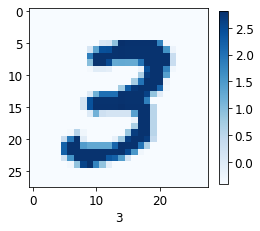

In [4]:
img,l = mnist_data.__getitem__(7)
plt.imshow(img[0], cmap=color_theme)
plt.xlabel(str(l))
plt.colorbar(shrink=0.8)
plt.show()
img = img.to(torch.float64)

We denote input image by $I$. And by $f*I$, we will denote the convolution of image $I$ with some filter $f$. And we will denote the scaling operation by $G_s[I]$. In our case, the scaling operation $G_s$ is ideal resampling operation.

Now, any operation, $P$, on the image $I$ will ve scale equivarinat if it commutes with the scaling operation $G_s$, i.e. $$ G_s[P(I)] = P(G_s[I])$$


### Scale Equivarinat Convolution <a class="anchor" id="conv_layer"></a>

To attain scale-equivariant convolution, we execute the operation in the Fourier domain. While understanding local features is crutial in computer vision, spectral convolution functions globally. To capture local features effectively, we present a localized Fourier filter, imposing constrain in Spectral domain which ensures appropriate localization of the spatial kernel.

In [6]:
'''
local modes: Active size of the Filter (Filter is 0 outside this size)
global_modes: Global size of the Filter (Max size of Training Images)
'''
conv = SpectralConv2dLocalized(in_channel=1, out_channel=1,global_modes=28,local_modes=3)
filter = conv.get_filters()
filter_fourier_coefficients = conv.get_filters_spectral()
s_filter = conv.get_filters_spectral()

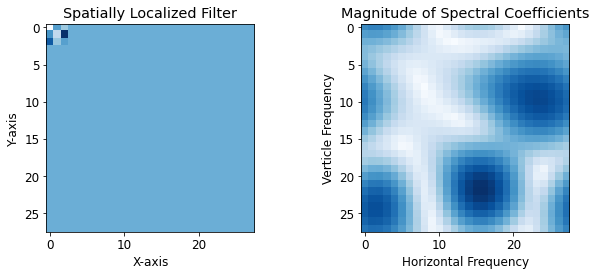

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].imshow(filter[0, 0].real.detach(), cmap=color_theme)
axs[0].set_title('Spatially Localized Filter')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')

axs[1].imshow(torch.fft.fftshift(torch.abs(s_filter[0, 0]).detach()), cmap=color_theme)
axs[1].set_title('Magnitude of Spectral Coefficients')
axs[1].set_xlabel('Horizontal Frequency')
axs[1].set_ylabel('Verticle Frequency')
plt.tight_layout()
plt.show()

In [8]:
with torch.no_grad():
        conv_out = torch.fft.ifft2(conv(torch.fft.fft2(img[None,], norm='forward')), norm='forward').real
        img_scaled = resample(img[None,], (16,16),complex=False, skip_nyq=True)[0]
        conv_out_scaled = torch.fft.ifft2(conv(torch.fft.fft2(img_scaled[None], norm='forward')), norm='forward').real
        scaled_conv_out = resample(conv_out, (16,16), complex=False, skip_nyq=True)
        diff = scaled_conv_out - conv_out_scaled

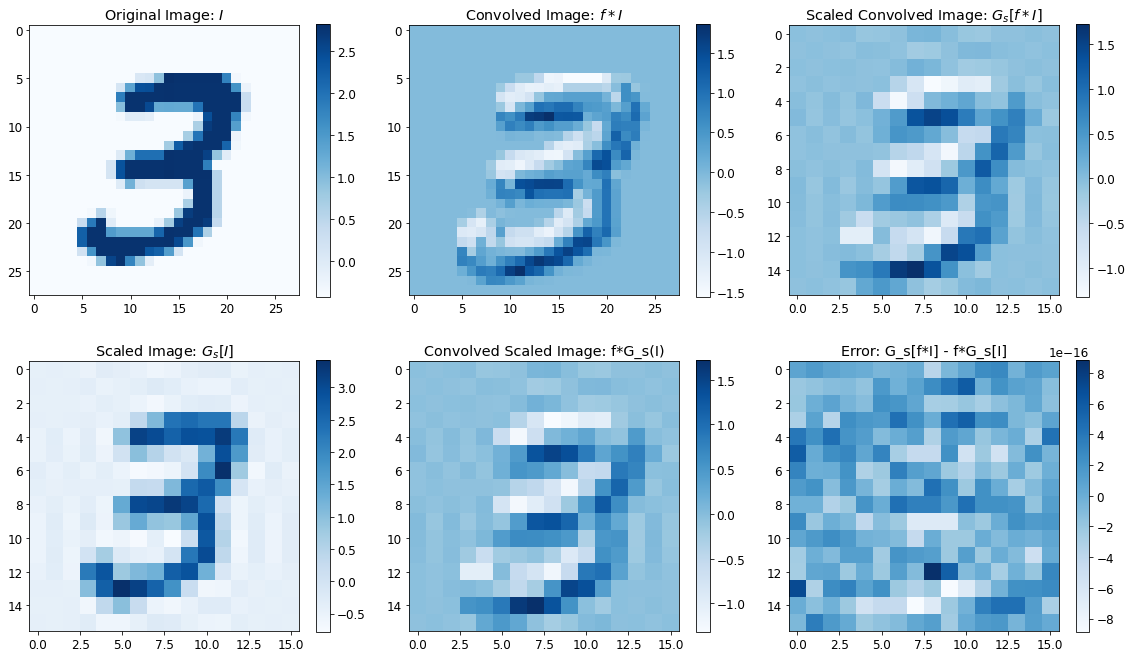

Equivariant Error: 4.237714647410726e-15


In [9]:
## ploting routine
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
img_plot = axs[0, 0].imshow(img[0], cmap=color_theme)
plt.colorbar(img_plot, ax=axs[0, 0], shrink=0.85)
axs[0, 0].set_title("Original Image: $I$")
conv_plot = axs[0, 1].imshow(conv_out[0, 0].detach(), cmap=color_theme)
plt.colorbar(conv_plot, ax=axs[0, 1], shrink=0.85)
axs[0, 1].set_title("Convolved Image: $f*I$")
scon_plot= axs[0, 2].imshow(scaled_conv_out[0,0], cmap=color_theme)
plt.colorbar(scon_plot, ax=axs[0, 2], shrink=0.85)
axs[0, 2].set_title("Scaled Convolved Image: $G_s[f *I]$")
simg_plot = axs[1, 0].imshow(img_scaled[0].detach(), cmap=color_theme)
plt.colorbar(simg_plot, ax=axs[1, 0], shrink=0.85)
axs[1, 0].set_title("Scaled Image: $G_s[I]$")
conv_scaled_plot = axs[1, 1].imshow(conv_out_scaled[0,0], cmap=color_theme)
plt.colorbar(conv_scaled_plot, ax=axs[1, 1], shrink=0.85)
axs[1, 1].set_title("Convolved Scaled Image: f*G_s(I)")
diff_plot = axs[1, 2].imshow(diff[0, 0].detach(), cmap=color_theme)
axs[1, 2].set_title("Error: G_s[f*I] - f*G_s[I]")
plt.colorbar(diff_plot, ax=axs[1, 2], shrink=0.85)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("Equivariant Error:", torch.norm(diff).item())

We can see that with our spacially local spectral convolution, the equivariance error is close to 0.

On the other hand, if we repeat the same process regular $3\times3$ convolution, we will find that, the operation is not Scale Equivarinat.

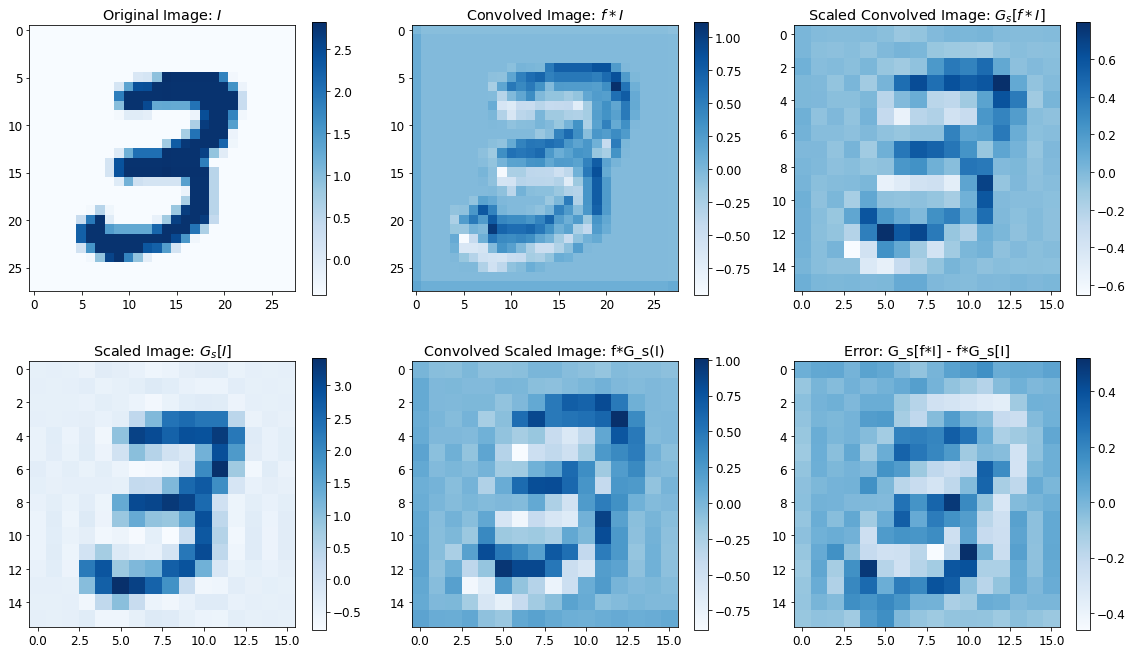

Equivariant Error: 2.473854607436901


In [10]:
regular_conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1).to(img.dtype)

with torch.no_grad():
        conv_out = regular_conv(img[None,])
        img_scaled = resample(img[None,], (16,16),complex=False, skip_nyq=True)[0]
        conv_out_scaled = regular_conv(img_scaled[None])
        scaled_conv_out = resample(conv_out, (16,16), complex=False, skip_nyq=True)
        diff = scaled_conv_out - conv_out_scaled
        
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
img_plot = axs[0, 0].imshow(img[0], cmap=color_theme)
plt.colorbar(img_plot, ax=axs[0, 0], shrink=0.85)
axs[0, 0].set_title("Original Image: $I$")
conv_plot = axs[0, 1].imshow(conv_out[0, 0].detach(), cmap=color_theme)
plt.colorbar(conv_plot, ax=axs[0, 1], shrink=0.85)
axs[0, 1].set_title("Convolved Image: $f*I$")
scon_plot= axs[0, 2].imshow(scaled_conv_out[0,0], cmap=color_theme)
plt.colorbar(scon_plot, ax=axs[0, 2], shrink=0.85)
axs[0, 2].set_title("Scaled Convolved Image: $G_s[f *I]$")
simg_plot = axs[1, 0].imshow(img_scaled[0].detach(), cmap=color_theme)
plt.colorbar(simg_plot, ax=axs[1, 0], shrink=0.85)
axs[1, 0].set_title("Scaled Image: $G_s[I]$")
conv_scaled_plot = axs[1, 1].imshow(conv_out_scaled[0,0], cmap=color_theme)
plt.colorbar(conv_scaled_plot, ax=axs[1, 1], shrink=0.85)
axs[1, 1].set_title("Convolved Scaled Image: f*G_s(I)")
diff_plot = axs[1, 2].imshow(diff[0, 0].detach(), cmap=color_theme)
axs[1, 2].set_title("Error: G_s[f*I] - f*G_s[I]")
plt.colorbar(diff_plot, ax=axs[1, 2], shrink=0.85)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("Equivariant Error:", torch.norm(diff).item())

### Scale Equivarinat Non-Linearity <a class="anchor" id="non_linearity"></a>

Lets test the propsoed scale equivarinat non-linearity. Even though we are using ReLu, we can pass any activation function of our choice to the ```scaleEqNonlin``` class and can obtain a scale-equivarinat version of that non-linear activation.

Here, we will demosntrate Scale Equivarinat sigmoid function denated as $\sigma_e$. 

In [11]:
'''
max_res: Max scale of the image in consideration ( For example max resolution in dataset)
base_res: Lowest scale of the image in consideration
increment: resolutions (and corrsponding scales) to skip. increment = 1 means no scales will be skipped.
increment = 2, will skip every other scale. Layers will not be equivarinat to those scales.
'''

non_lin_of_choice = torch.sigmoid # any non-linearity will work
Sc_eq_activation = scaleEqNonlin(non_lin_of_choice, base_res=8, normalization=None,\
                                 max_res=28, increment=1,channels=1)

Making Non_lin layer, Max res 28  Increment 1


In [12]:
with torch.no_grad():
    non_lin = torch.fft.ifft2(Sc_eq_activation(torch.fft.fft2(img[None,...],norm='forward')),norm='forward').real
    img_scaled = resample(img[None,], (16,16),complex=False, skip_nyq=True)[0]
    non_lin_scaled = torch.fft.ifft2(Sc_eq_activation(torch.fft.fft2(img_scaled[None],norm='forward')),norm='forward').real
    #excluding the Nyquest Frequency as FFT can not determine it's complex part for real data
    non_lin_scaled = resample(non_lin_scaled, (16,16),complex=False, skip_nyq=True)
    
    scaled_non_lin = resample(non_lin, (16,16),complex=False, skip_nyq=True)
    diff = scaled_non_lin - non_lin_scaled

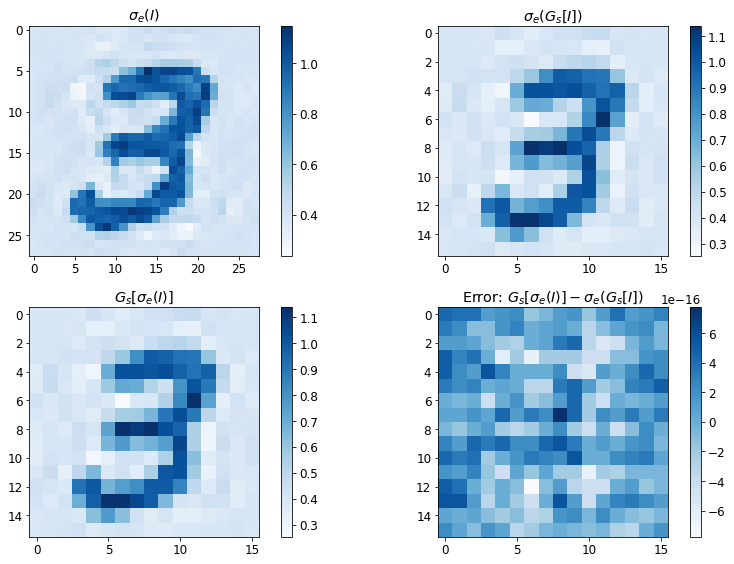

Equivariant Error: 4.318467880798754e-15


In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(non_lin[0, 0].detach().real, cmap=color_theme)
axs[0, 0].set_title("$\sigma_e(I)$")
plt.colorbar(axs[0, 0].imshow(non_lin[0, 0].detach().real, cmap=color_theme), ax=axs[0, 0])
axs[0, 1].imshow(non_lin_scaled[0, 0].detach().real, cmap=color_theme)
axs[0, 1].set_title("$\sigma_e(G_s[I])$")
plt.colorbar(axs[0, 1].imshow(non_lin_scaled[0, 0].detach().real, cmap=color_theme), ax=axs[0, 1])
axs[1, 0].imshow(scaled_non_lin[0, 0].detach().real, cmap=color_theme)
axs[1, 0].set_title("$G_s[\sigma_e(I)]$")
plt.colorbar(axs[1, 0].imshow(scaled_non_lin[0, 0].detach().real, cmap=color_theme), ax=axs[1, 0])
axs[1, 1].imshow(diff[0, 0].detach().real, cmap=color_theme)
axs[1, 1].set_title("Error: $G_s[\sigma_e(I)]-\sigma_e(G_s[I])$")
plt.colorbar(axs[1, 1].imshow(diff[0, 0].detach().real, cmap=color_theme), ax=axs[1, 1])
plt.tight_layout()
plt.show()
print("Equivariant Error:", torch.norm(diff).item())

Now, lets observe the situation with regular Sigmoid function applied pointwise.

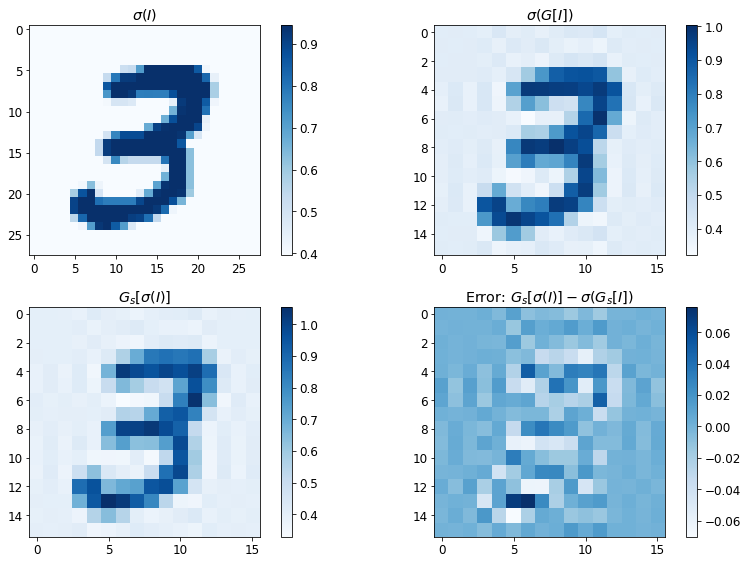

Equivariant Error: 0.3099930893343852


In [14]:
non_lin = non_lin_of_choice(img[None,...])
img_scaled = resample(img[None,], (16,16),complex=False, skip_nyq=True)[0]
non_lin_scaled = non_lin_of_choice(img_scaled[None])
#excluding the Nyquest Frequency as FFT can not determine it's complex part for real data
non_lin_scaled = resample(non_lin_scaled, (16,16),complex=False, skip_nyq=True)    
scaled_non_lin = resample(non_lin, (16,16),complex=False, skip_nyq=True)
diff = scaled_non_lin - non_lin_scaled

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(non_lin[0, 0].detach().real, cmap=color_theme)
axs[0, 0].set_title("$\sigma(I)$")
plt.colorbar(axs[0, 0].imshow(non_lin[0, 0].detach().real, cmap=color_theme), ax=axs[0, 0])
axs[0, 1].imshow(non_lin_scaled[0, 0].detach().real, cmap=color_theme)
axs[0, 1].set_title("$\sigma(G[I])$")
plt.colorbar(axs[0, 1].imshow(non_lin_scaled[0, 0].detach().real, cmap=color_theme), ax=axs[0, 1])
axs[1, 0].imshow(scaled_non_lin[0, 0].detach().real, cmap=color_theme)
axs[1, 0].set_title("$G_s[\sigma(I)]$")
plt.colorbar(axs[1, 0].imshow(scaled_non_lin[0, 0].detach().real, cmap=color_theme), ax=axs[1, 0])
axs[1, 1].imshow(diff[0, 0].detach().real, cmap=color_theme)
axs[1, 1].set_title("Error: $G_s[\sigma(I)]-\sigma(G_s[I])$")
plt.colorbar(axs[1, 1].imshow(diff[0, 0].detach().real, cmap=color_theme), ax=axs[1, 1])
plt.tight_layout()
plt.show()
print("Equivariant Error:", torch.norm(diff).item())

### Scale Equivarinat CNNs <a class="anchor" id="CNN"></a>

Now, we will create a multi-layered CNN with scale equivarinat layers. And we will show the whole achitecture is Scale Equivariant.

We denote the features extracted by the CNN  as $M(I)$.

In [16]:
class ScaleEqModel(nn.Module):
    def __init__(self,):
        super(ScaleEqModel, self).__init__()
        self.conv1 = SpectralConv2dLocalized(in_channel=1, out_channel=16,\
                                             global_modes=28,local_modes=5)
        self.non_linear1 = scaleEqNonlinMaxp(nn.functional.sigmoid, 8,\
                                             normalization = None, channels = 16,\
                                             pool_window = 2, max_res = 28, increment = 1)

        # note that for the following layers, we use the global_modes = 14, which half of the previous layers
        # this is because of the max_pool by window size of 2, whihc scales down by 2. (28 -> 14). 
        # Same Goes for the base base_res(8->4)
        self.conv2 = SpectralConv2dLocalized(in_channel=16, out_channel=32,\
                                             global_modes=14,local_modes=5)

        #Not doing max pool in the last layer
        self.non_linear2 = scaleEqNonlin(nn.functional.sigmoid, 4,\
                                         normalization = None, channels = 32,\
                                         max_res = 14, increment = 1)
        
        self.linear = nn.Linear(32*14*14, 10)
    
    def get_feature(self, x):
        x_ft = torch.fft.fft2(x, norm = 'forward')
        c1 = self.conv1(x_ft)
        n1 = self.non_linear1(c1)
        c2 = self.conv2(n1)
        n2 = self.non_linear2(c2)
        features = torch.fft.ifft2(n2, norm = 'forward').real
        return features

    def forward(self, x):
        features = self.get_feature(x)
        # reshape features to a fixed size
        features_fixed_size = resample(features, (14,14))
        logits = self.linear(features_fixed_size.reshape(features_fixed_size.shape[0], -1))
        return logits.real

model = ScaleEqModel().to(torch.cdouble)

Making Non_lin layer, Max res 14  Increment 1


Here the final features of out mode will be down-scaled by a factor of 2 due to the max-pooling operation.

In [18]:
with torch.no_grad():
    model_out = model.get_feature(img[None,...]) # output shape (..., 14x14)
    
    img_scaled = resample(img[None,], (16,16),\
                          complex=False, skip_nyq=True)[0] # down-scaled image size 16x16 
    
    model_out_scaled = model.get_feature(img_scaled[None]) #output size 8x8

    #removing the Nyquest
    model_out_scaled = resample(model_out_scaled, (8,8),complex=False, skip_nyq=True)
    
    scaled_model_out = resample(model_out, (8,8),complex=False, skip_nyq=True)
    diff = scaled_model_out - model_out_scaled

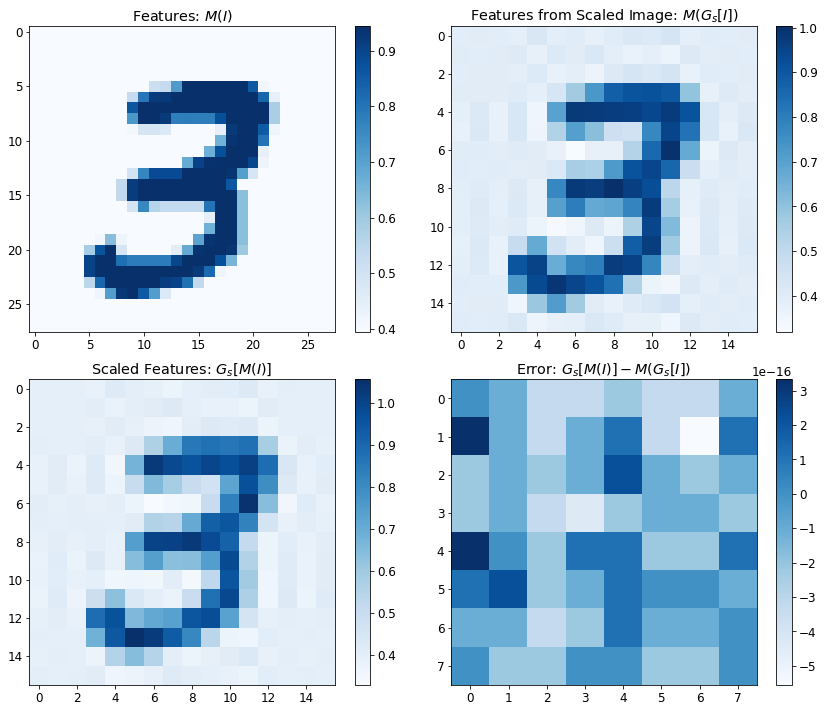

Equivariant Error: 9.573541399996936e-15


In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].imshow(model_out[0, 0].detach().real, cmap=color_theme)
axs[0, 0].set_title("Features: $M(I)$")
plt.colorbar(axs[0, 0].imshow(non_lin[0, 0].detach().real, cmap=color_theme), ax=axs[0, 0])
axs[0, 1].imshow(model_out_scaled[0, 0].detach().real, cmap=color_theme)
axs[0, 1].set_title("Features from Scaled Image: $M(G_s[I])$")
plt.colorbar(axs[0, 1].imshow(non_lin_scaled[0, 0].detach().real, cmap=color_theme), ax=axs[0, 1])
axs[1, 0].imshow(scaled_model_out[0, 0].detach().real, cmap=color_theme)
axs[1, 0].set_title("Scaled Features: $G_s[M(I)]$")
plt.colorbar(axs[1, 0].imshow(scaled_non_lin[0, 0].detach().real, cmap=color_theme), ax=axs[1, 0])
axs[1, 1].imshow(diff[0, 0].detach().real, cmap=color_theme)
axs[1, 1].set_title("Error: $G_s[M(I)]-M(G_s[I])$")
plt.colorbar(axs[1, 1].imshow(diff[0, 0].detach().real, cmap=color_theme), ax=axs[1, 1])
plt.tight_layout()
plt.show()
print("Equivariant Error:", torch.norm(diff).item())

### Scale Equivarinat Linear Layer <a class="anchor" id="linear_layer"></a>

Now we will explore scale equivarinat linear layer. Given a singnal $f$ of lenght $N$, a linear operation on the signal is represented as $f_{out} = W \times f$, where $W$ is $N\times N$ matrix.

In general this operation is not scale equivarinat. But following our claim on scale equivarinat operation, we can construct scale Equivarinat Linear Layer. We demote the linear layer as $L$.

We have two modules ```SpectralMixer_1D``` ,and ```SpectralMixer_2D``` for signal on 1D and 2D domain respectively.

In [25]:
import torchaudio
from utils.core_utils import resample_1d 
plt.rcParams["figure.figsize"] = (30,7)
plt.rcParams.update({
    'font.size': 16,
})

In [26]:
yesno_data = torchaudio.datasets.YESNO('./data', download=True)

In [27]:
p = yesno_data.__getitem__(6)

For visualization we will reduce the length (time duration) of the audio signals. Here, we denote the audio signal as $f$ and its' Fourier Transform a $F$.

In [39]:
f = p[0][0,6500:7000].to(torch.double)

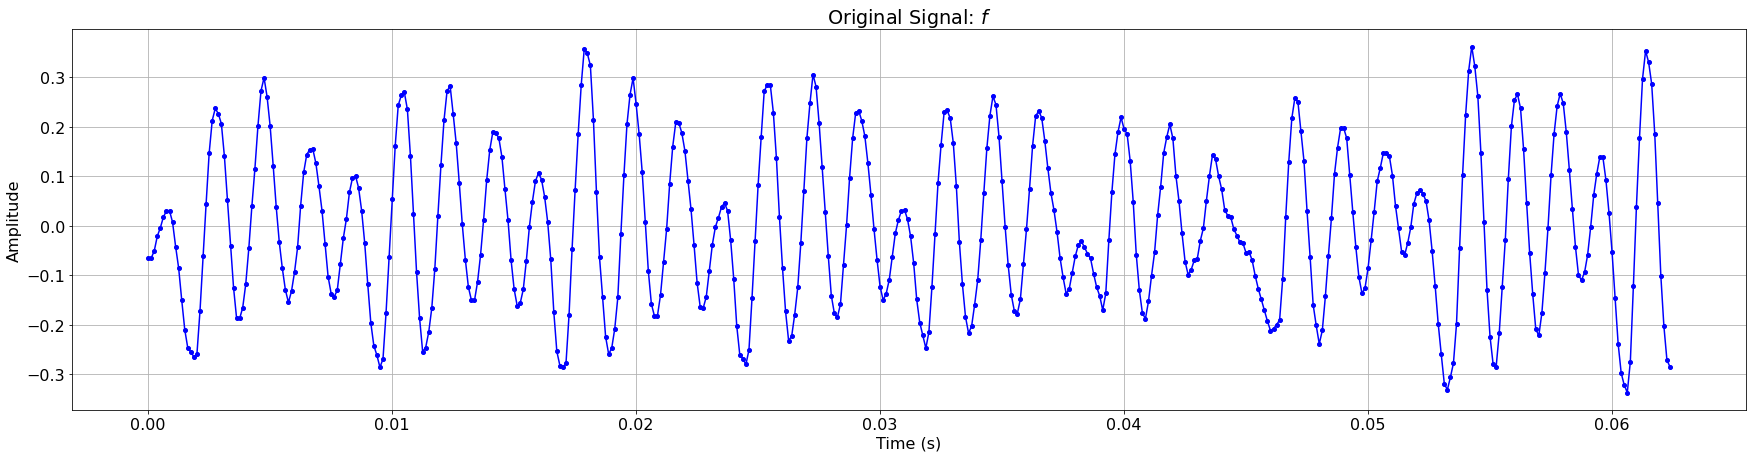

In [40]:
plt.plot([i/8000 for i in range(f.shape[-1])],f, marker='o', markersize=4, linestyle='-', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Signal: $f$')
plt.grid(True)
plt.show()

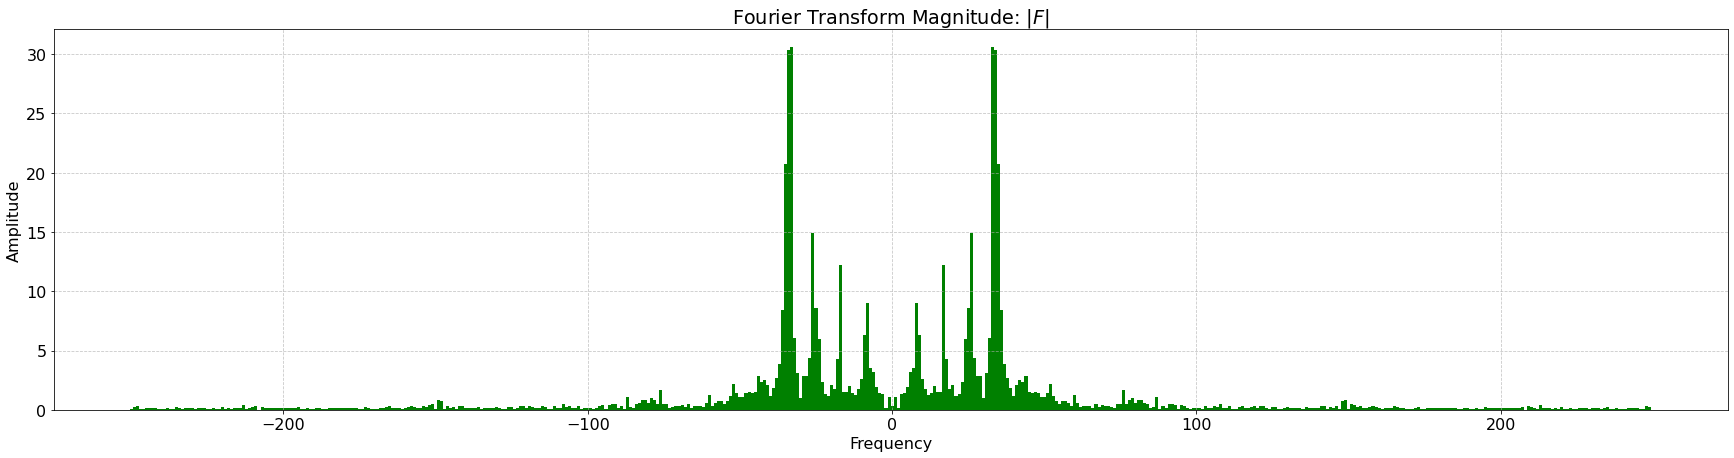

In [41]:
F = torch.fft.fftshift(torch.fft.fft(f))
plt.bar([i-F.shape[-1]//2 for i in range(F.shape[-1])],torch.abs(F), color='green', width=1.0)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier Transform Magnitude: $|F|$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [42]:
from layers.spectral_mixer import SpectralMixer_1D, SpectralMixer_2D
'''
num_channels: Number of Co-domain of the input signal
mode_size: Maximum number of Fourier models to use. Normally can be set to size of the input signal.
mixer_band: Limits the number of neighboring Fourier models to mix with each other. Deafults to -1 implies no limit on mixing.
'''
s_eq_linear = SpectralMixer_1D( num_channels=1, mode_size=500, mixer_band=10)

In [43]:
with torch.no_grad():
    f_out = torch.fft.ifft(s_eq_linear(torch.fft.fft(f[None,None,...],\
                                                     norm='forward'), 500), norm='forward')   
    f_scaled = resample_1d(f[None,None,...], 250, skip_nyq=True)
    f_scaled_out = torch.fft.ifft(s_eq_linear(torch.fft.fft(f_scaled,\
                                                            norm='forward'), 250), norm='forward')
    f_scaled_out = resample_1d(f_scaled_out, 250, skip_nyq=True)
    scaled_f_out =  resample_1d(f_out, 250, skip_nyq=True)

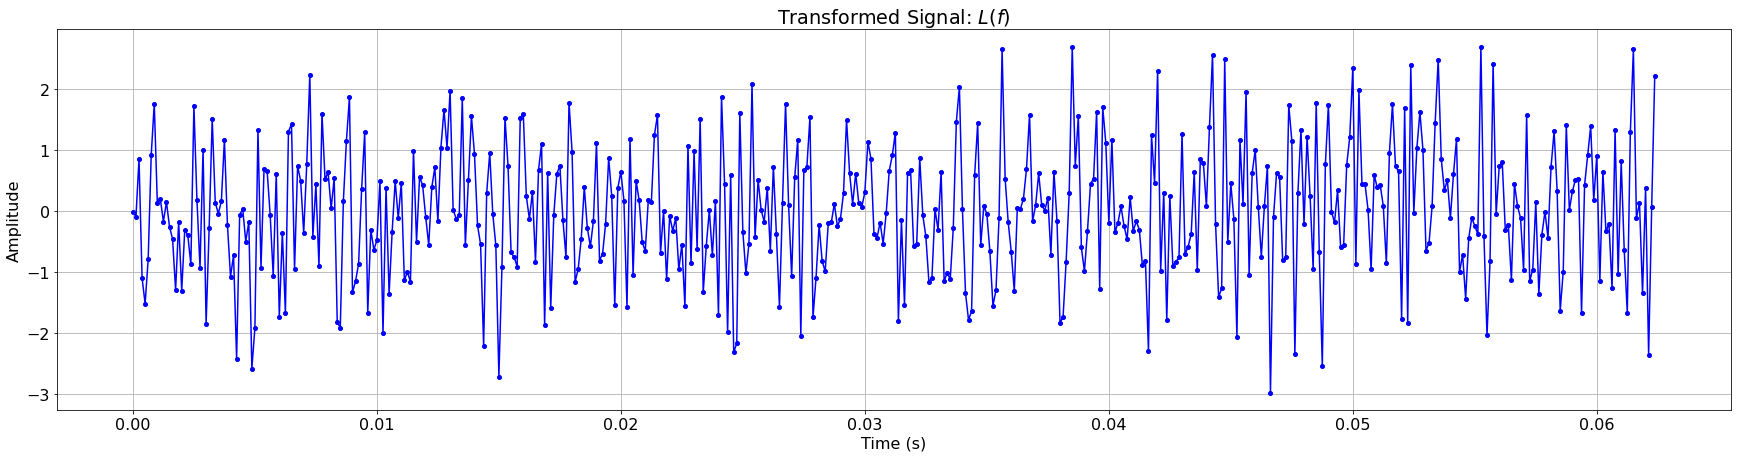

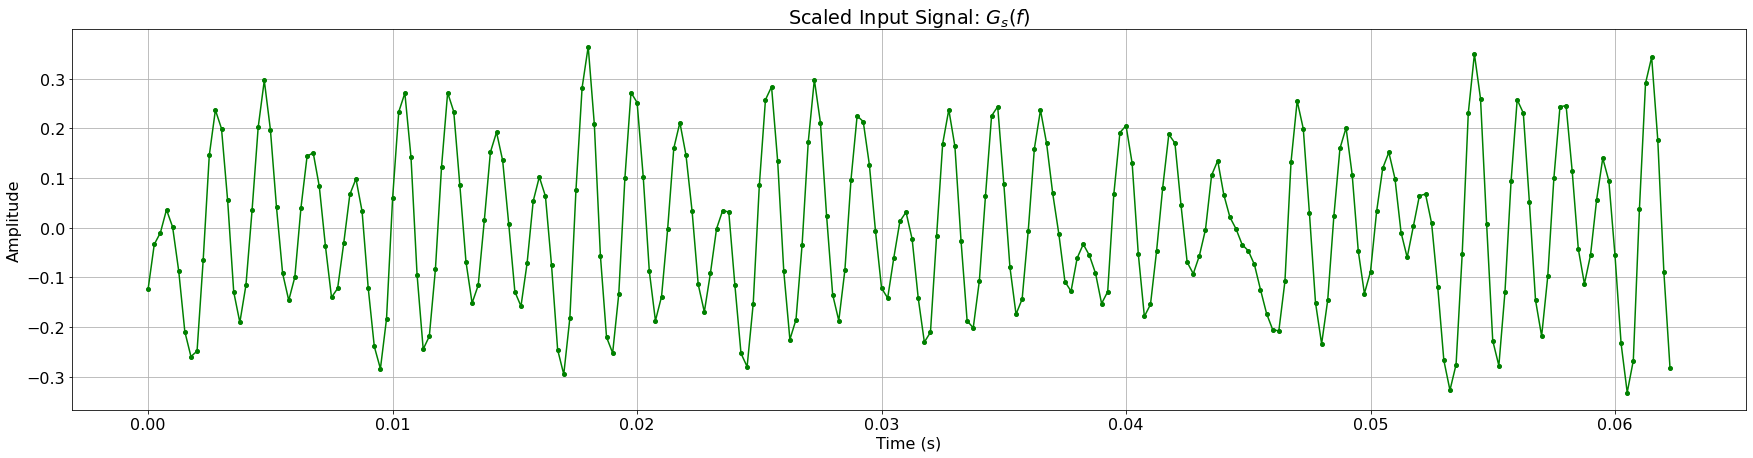

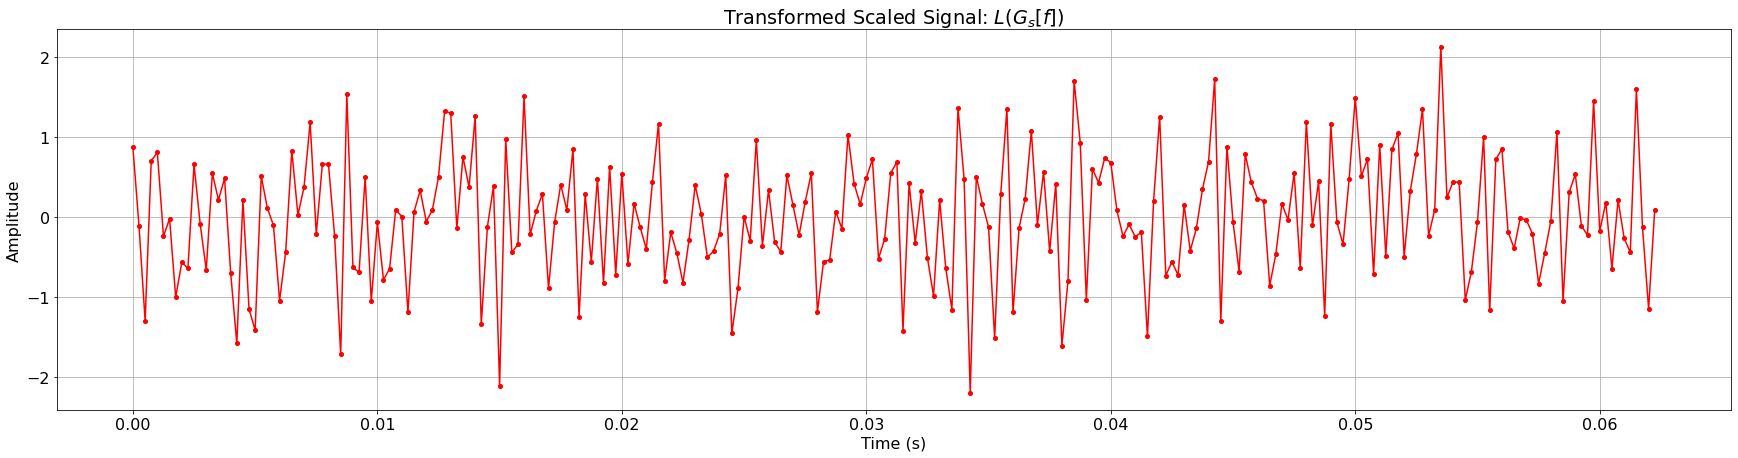

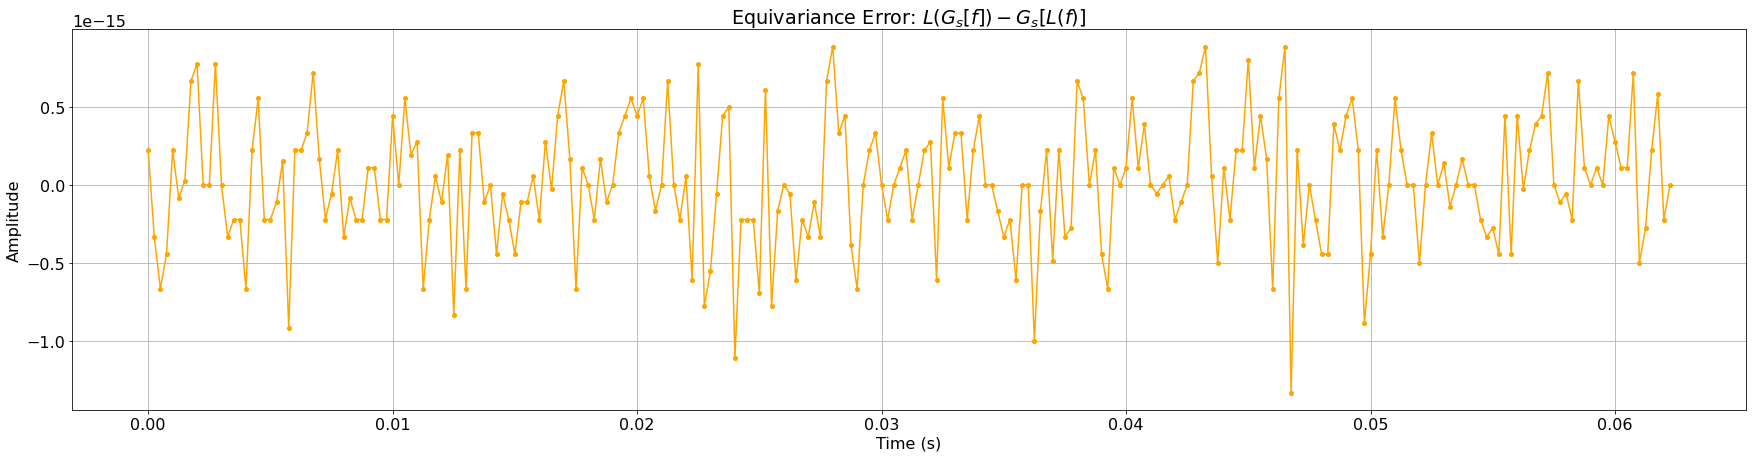

Equivariant Error: 6.267200369528819e-15


In [44]:
time_values = [i / 8000 for i in range(f_out.shape[-1])]
plt.plot(time_values, f_out[0, 0].real, marker='o', markersize=4, linestyle='-', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Transformed Signal: $L(f)$')
plt.grid(True)
plt.show()

# Compute f_scaled
time_values = [i / 4000 for i in range(f_scaled.shape[-1])]
plt.plot(time_values, f_scaled[0, 0].real, marker='o', markersize=4, linestyle='-', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Scaled Input Signal: $G_s(f)$')
plt.grid(True)
plt.show()

# Compute f_scaled_out
time_values = [i / 4000 for i in range(f_scaled_out.shape[-1])]
plt.plot(time_values, f_scaled_out[0, 0].real, marker='o', markersize=4, linestyle='-', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Transformed Scaled Signal: $L(G_s[f])$')
plt.grid(True)
plt.show()

# Compute difference signal
diff = (f_scaled_out[0, 0] - scaled_f_out[0, 0]).real
time_values = [i / 4000 for i in range(diff.shape[-1])]
plt.plot(time_values, diff, marker='o', markersize=4, linestyle='-', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Equivariance Error: $L(G_s[f]) - G_s[L(f)]$')
plt.grid(True)
plt.show()
print("Equivariant Error:", torch.norm(diff).item())

Together with the this scale equivarinat linear operation and activtion ```scaleEqNonlin1d```, we can also construct Fully connected Scale Equivariant network. 